In [2]:
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
root = Path.cwd().parent
sys.path.append(str(root))
plt.rcParams.update({"text.usetex": True, "font.family": "Computer Modern"}) 

from data.materials import hardening
from configs.materials import materials
from data.generators import InputsSignals

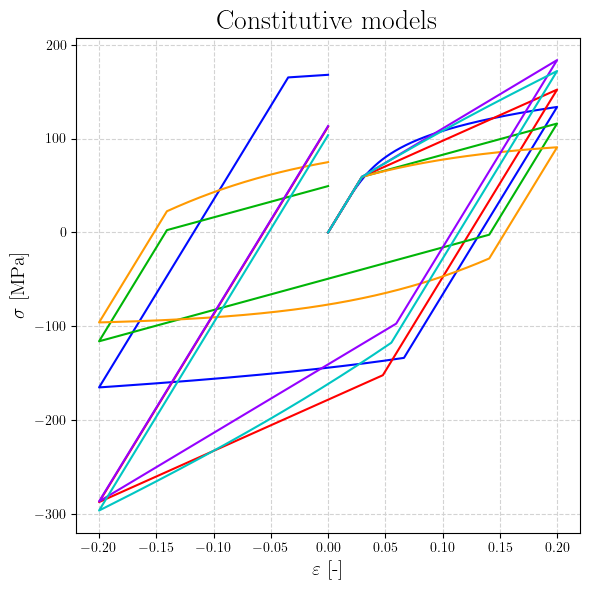

In [3]:
eps_max = 0.2

plt.figure(figsize=(6,6),dpi=100)
plt.title('Constitutive models',fontsize=20)
eps = np.concatenate([
    np.linspace(0,eps_max,1000),
    np.linspace(eps_max,-eps_max,1000),
    np.linspace(-eps_max,0,1000)
])
for name, mat in materials.items():
    sig, _, _ = hardening(eps,mat['E'],mat['dalpha'],mat['Y'])
    plt.plot(eps,sig/1e6,label=name,color=materials[name]['color'],lw=1.5)
# plt.legend(loc='upper left',fontsize=10)
plt.xlabel(r'$\varepsilon$ [-]',fontsize=14)
plt.ylabel(r'$\sigma$ [MPa]',fontsize=14)
plt.grid(ls='--',c='lightgray')
plt.tight_layout()
plt.show()

In [4]:
folder_path = Path('..','data','input','random')
random_inputs = [InputsSignals(file) for file in folder_path.iterdir()]

folder_path = Path('..','data','input','static')
static_inputs = [InputsSignals(file) for file in folder_path.iterdir()]

/tmp/ipykernel_3155/2863253161.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[0].boxplot(
/tmp/ipykernel_3155/2863253161.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[1].boxplot(


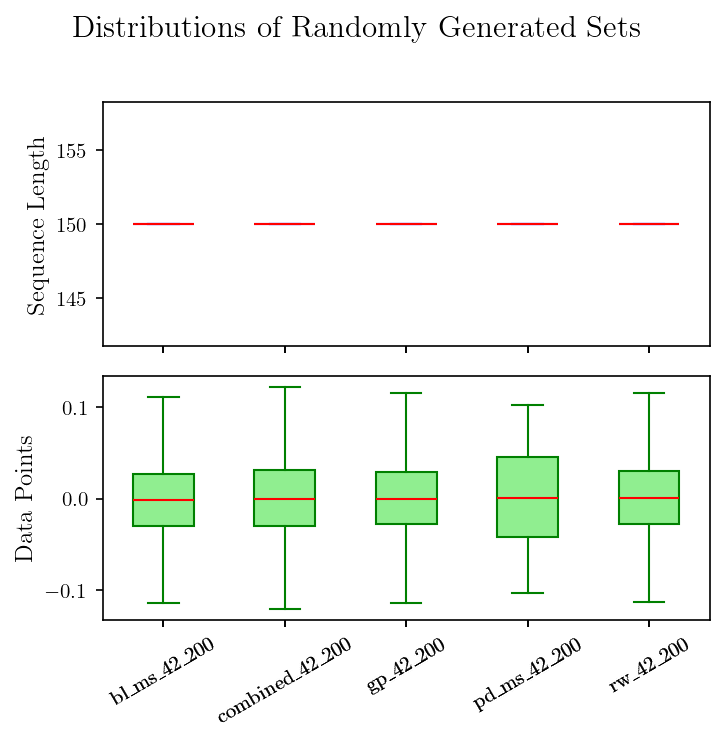

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(5, 5), dpi=150, sharex=True)
fig.suptitle('Distributions of Randomly Generated Sets', fontsize=15)

# Sequence lengths
ax[0].boxplot(
    [data.lengths for data in random_inputs],
    tick_labels=[data.name for data in random_inputs],
    showfliers=False,   # hide outliers
    patch_artist=True,  # fill boxes with color
    boxprops=dict(facecolor='lightblue', color='blue'),
    medianprops=dict(color='red'),
    whiskerprops=dict(color='blue'),
    capprops=dict(color='blue')
)
ax[0].set_ylabel('Sequence Length', fontsize=12)

# Data points
ax[1].boxplot(
    [np.concatenate(data_set.u_list) for data_set in random_inputs],
    tick_labels=[data_set.name for data_set in random_inputs],
    showfliers=False,   # hide outliers
    patch_artist=True,
    boxprops=dict(facecolor='lightgreen', color='green'),
    medianprops=dict(color='red'),
    whiskerprops=dict(color='green'),
    capprops=dict(color='green')
)
ax[1].set_ylabel('Data Points', fontsize=12)

plt.xticks(rotation=30)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


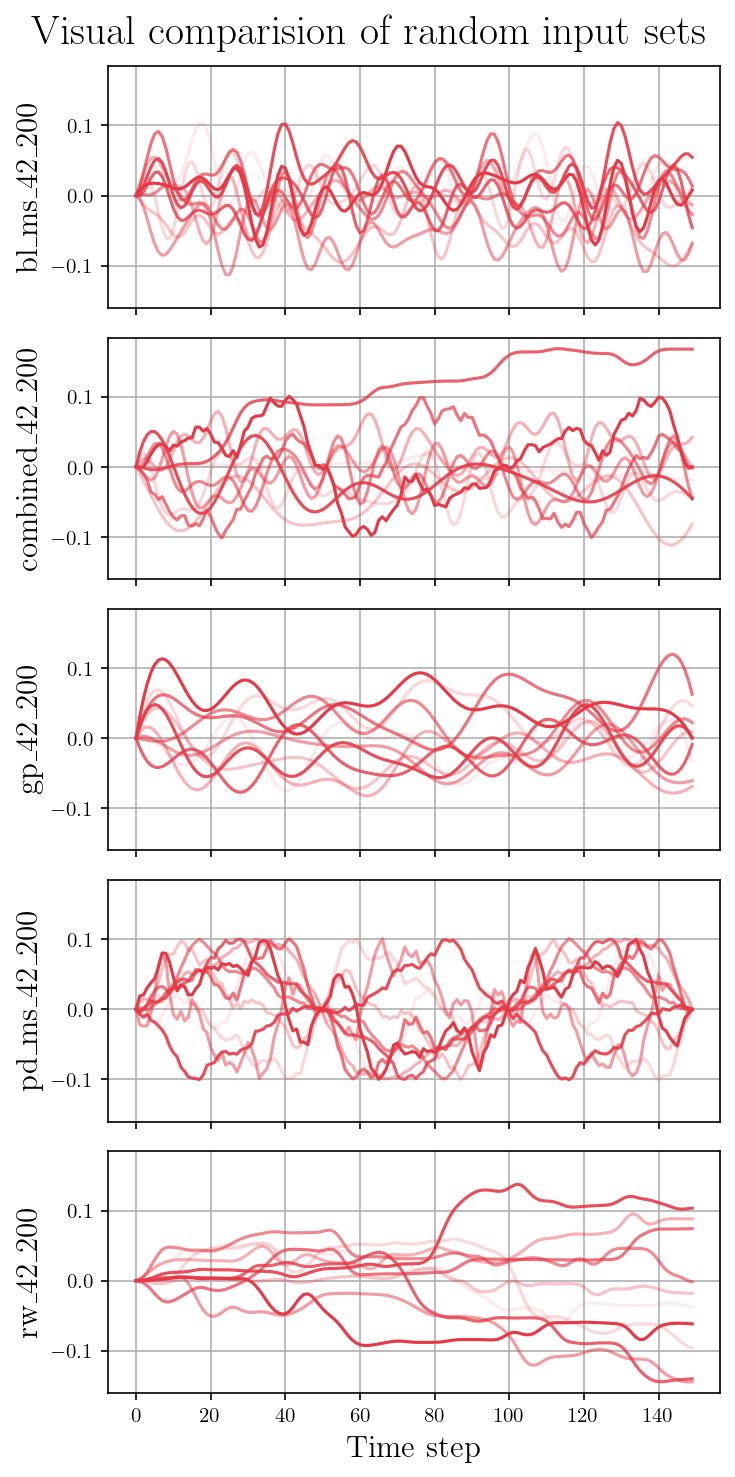

In [14]:
num = len(random_inputs)
fig, ax = plt.subplots(num,figsize=(5,2*num), dpi=150,sharex=True,sharey=True)
fig.suptitle('Visual comparision of random input sets',fontsize=20)

for i in range(num):
    random_inputs[i].plot_samples(ax=ax[i],num_samples=10)
    ax[i].set_ylabel(f'{random_inputs[i].name}',fontsize=15)
ax[-1].set_xlabel('Time step',fontsize=15)
plt.tight_layout()
plt.show()

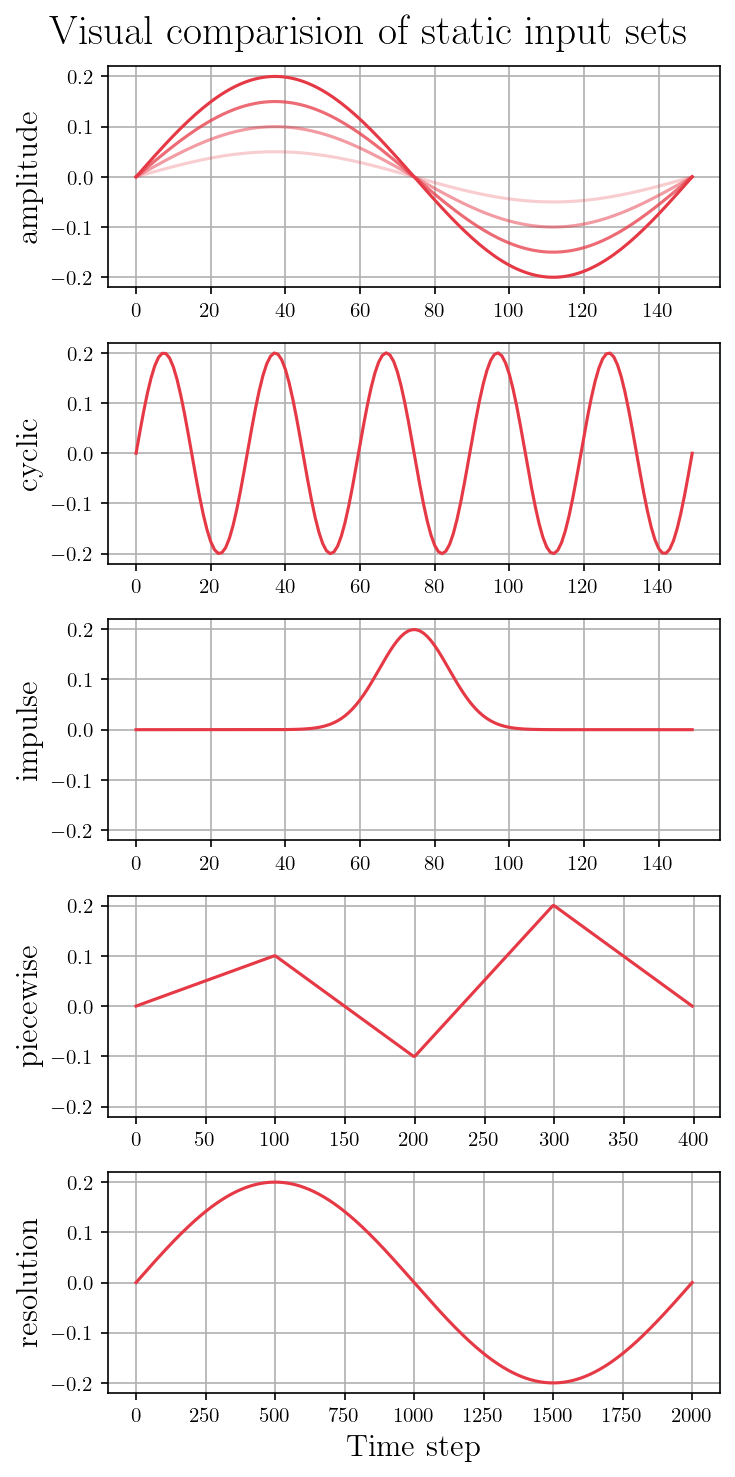

In [15]:
num = len(static_inputs)
fig, ax = plt.subplots(num,figsize=(5,2*num), dpi=150,sharex=False,sharey=True)
fig.suptitle('Visual comparision of static input sets',fontsize=20)

for i in range(num):
    static_inputs[i].plot_samples(ax=ax[i],num_samples=10)
    ax[i].set_ylabel(f'{static_inputs[i].name}',fontsize=15)
ax[-1].set_xlabel('Time step',fontsize=15)
plt.tight_layout()
plt.show()

# Check saved responeses

In [16]:
from data.materials import load_responses, plot_responses

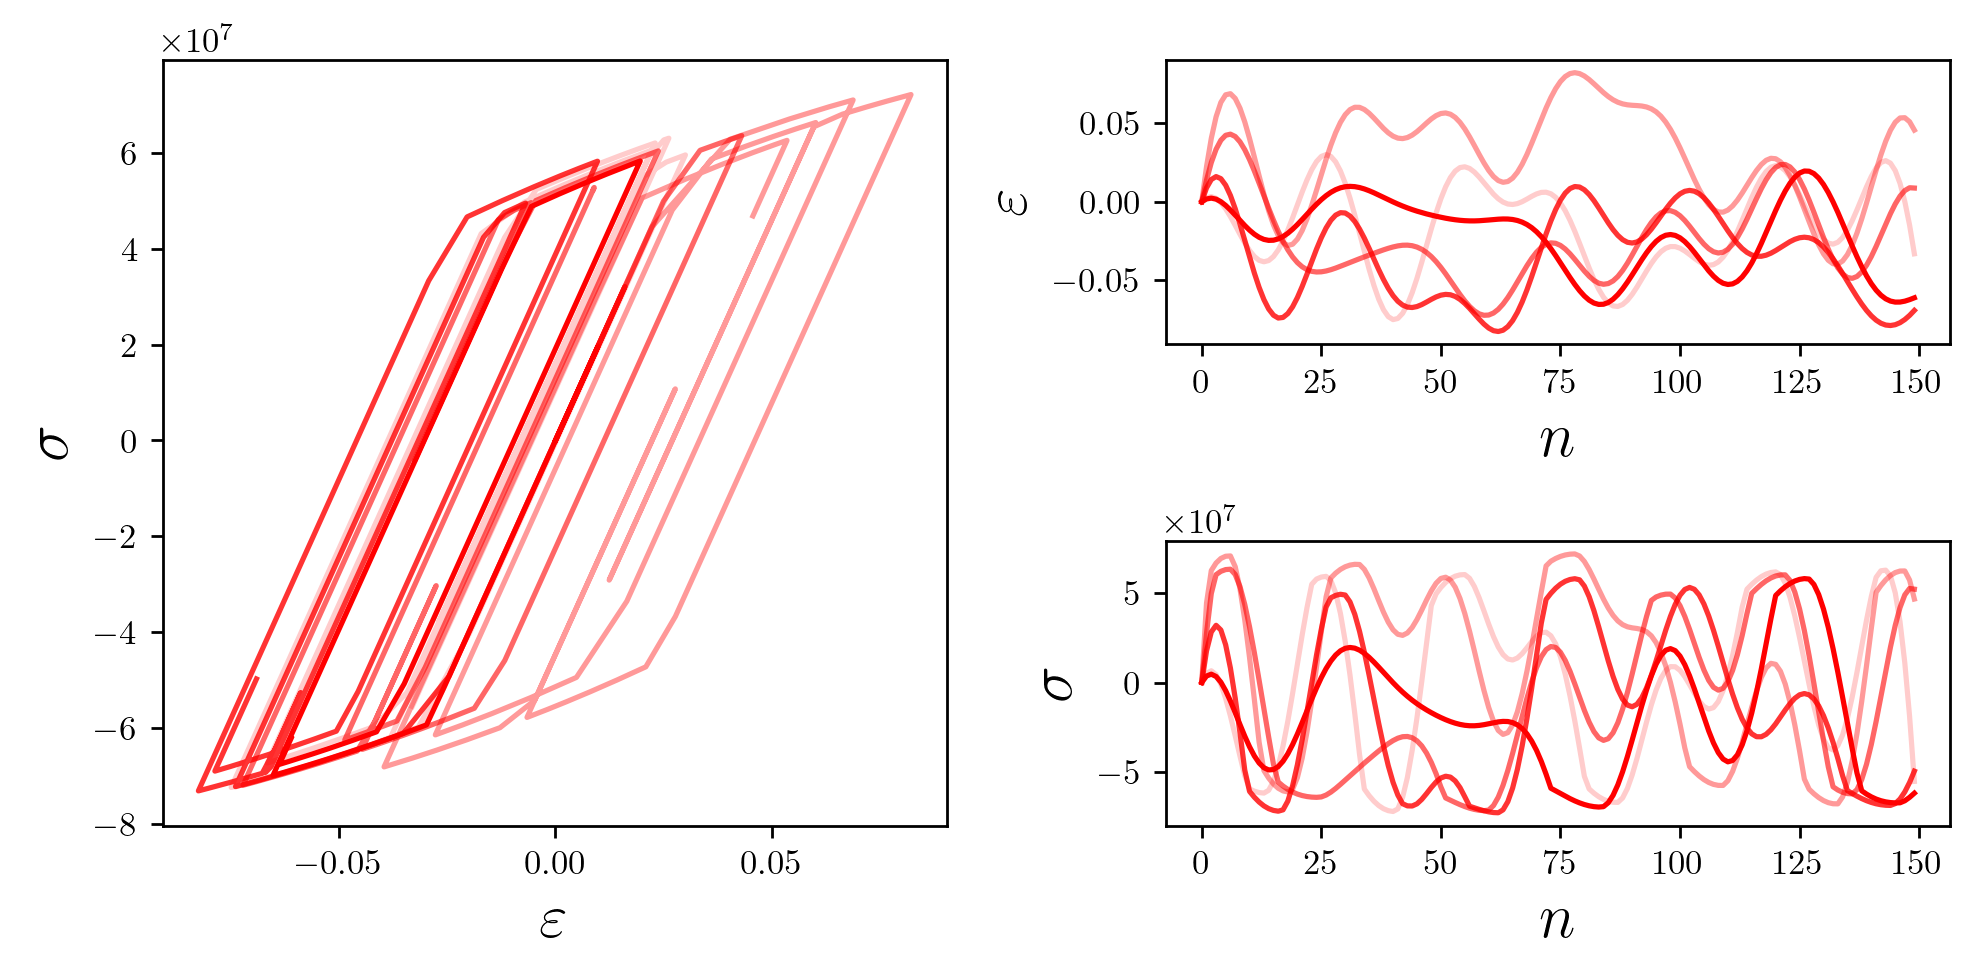

In [ ]:
mat_name = 'kinematic-armstrong-fredrick'
inp_type = 'random'
inp_name = 'gp_42_200'

eps_list, sig_list = load_responses(mat_name, inp_type, inp_name, data_dir='../data')
plot_responses(eps_list[:5], sig_list[:5])

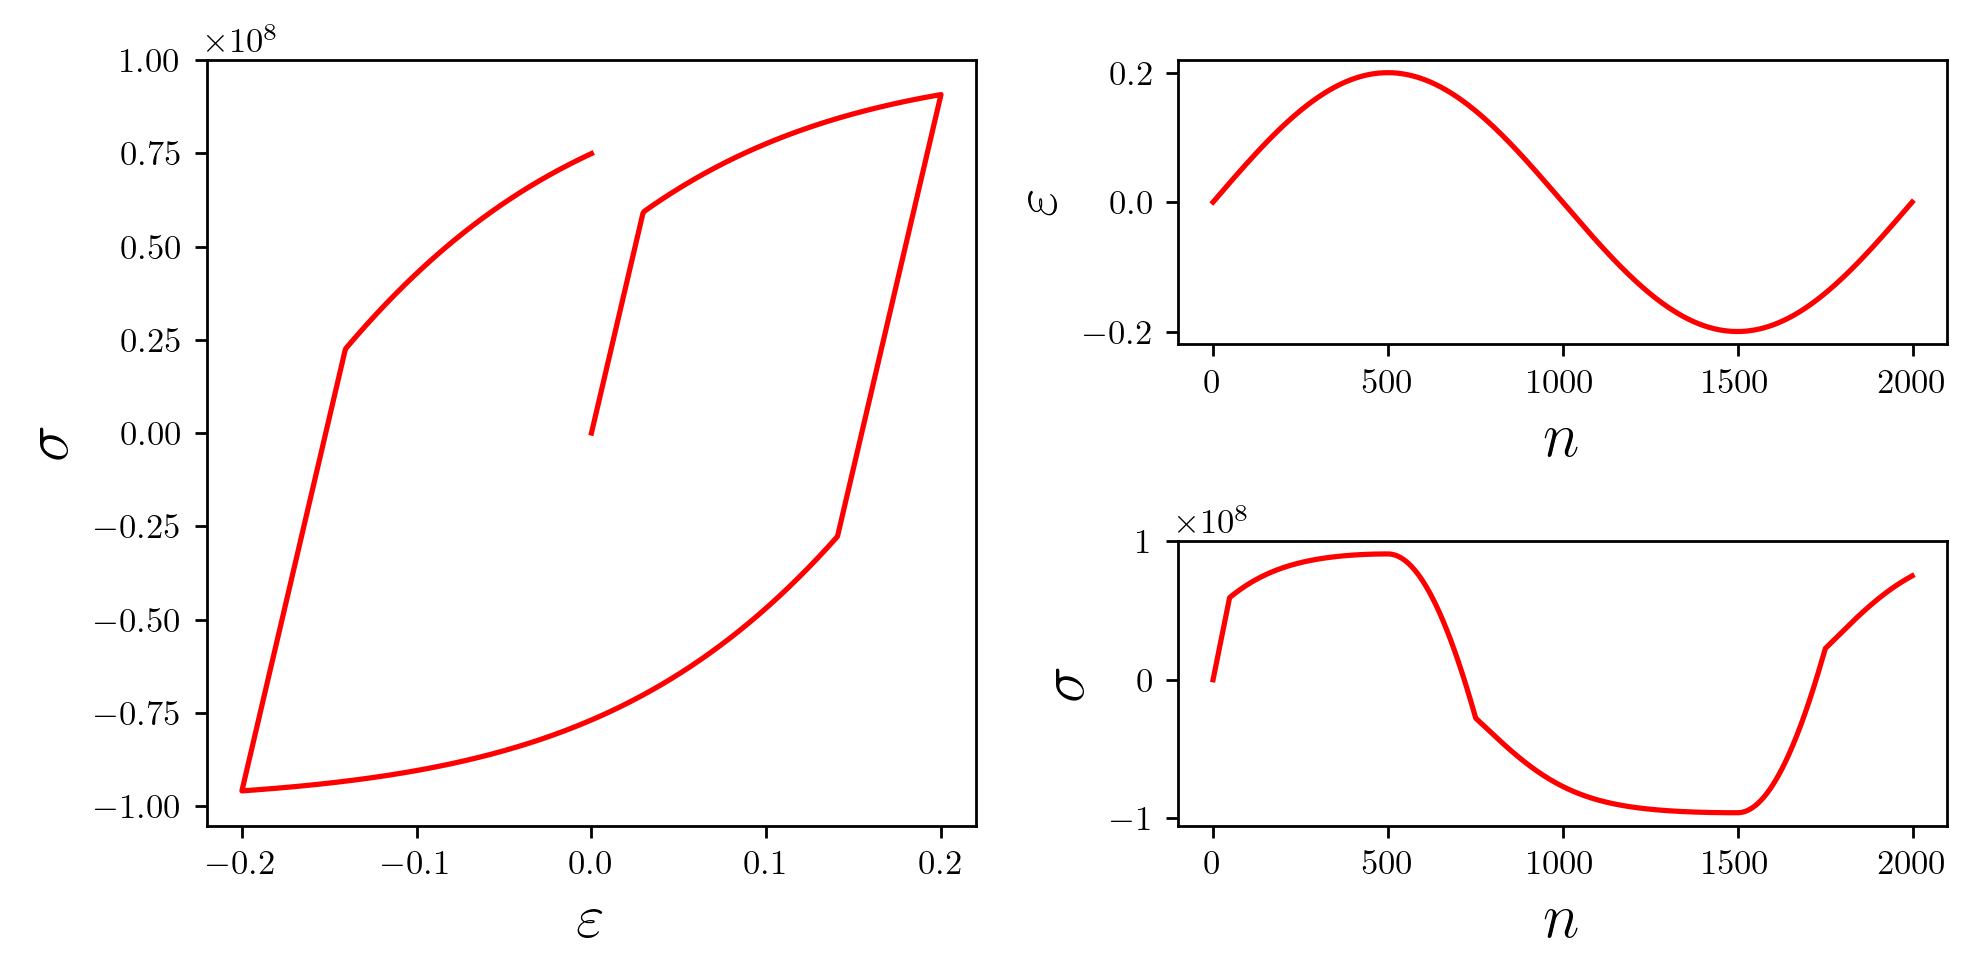

In [19]:
mat_name = 'kinematic-armstrong-fredrick'
inp_type = 'static'
inp_name = 'resolution'

eps_list, sig_list = load_responses(mat_name, inp_type, inp_name, data_dir='../data')
plot_responses(eps_list[:5], sig_list[:5])

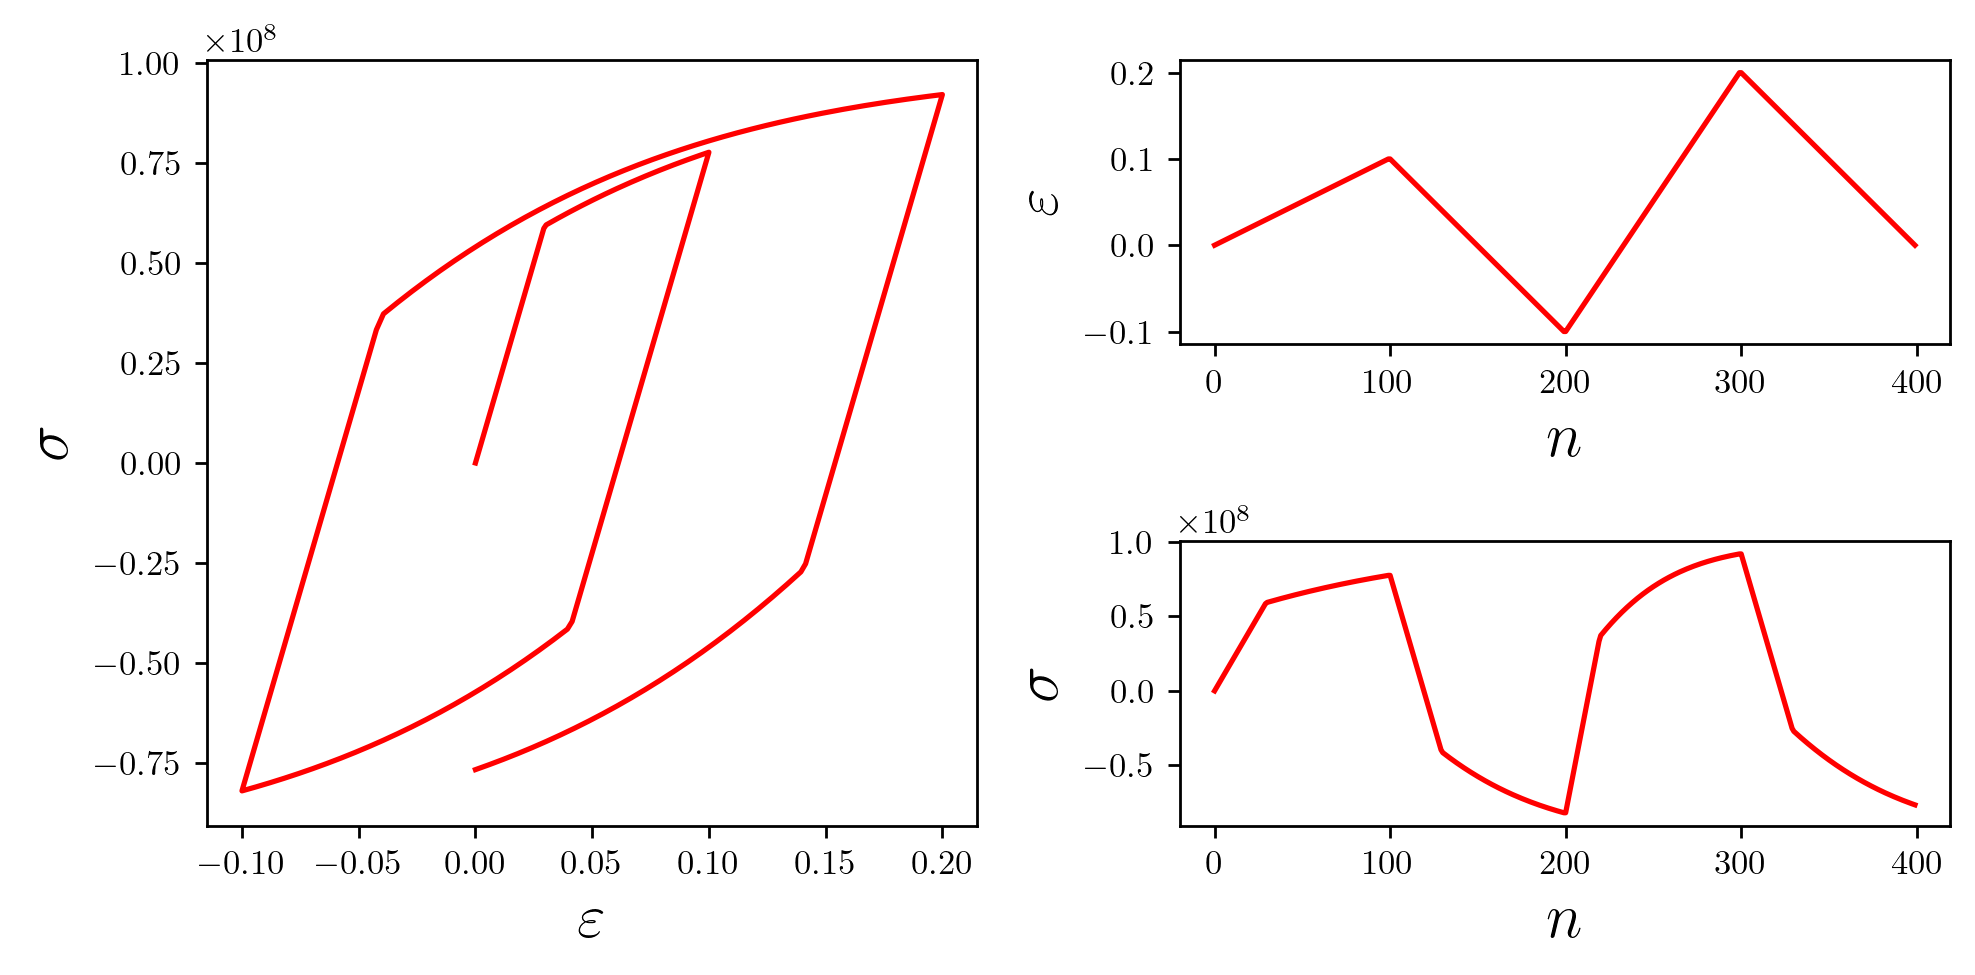

In [20]:
mat_name = 'kinematic-armstrong-fredrick'
inp_type = 'static'
inp_name = 'piecewise'

eps_list, sig_list = load_responses(mat_name, inp_type, inp_name, data_dir='../data')
plot_responses(eps_list[:5], sig_list[:5])